In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange

# Diffusion with reflecting and absorbing boundaries

We implement the handling of the boundary by augmenting the solver. After every timestep, it applies a boundary function, that somehow transforms those particles that have crossed the boundary.

In [97]:
# The Euler-Maruyama method
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dta
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

# A solver wrapper that can take a boundary handling function
# as an extra argument
def solve_SDE_variable(X0, xmin, xmax, h, tmax, dt, a, b, solver, q=2):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in trange(1, Nt):
        # Separate out those particles that are too close to the boundary
        mask = ~((np.abs(X[n-1,:] - xmin) < h) | (np.abs(X[n-1,:] - xmax) < h))
        
        # Call solver once for those particles that are away from boundaries
        X[n,~mask] = solver(X[n-1,~mask], t, dt, a, b)
        # Reflect from boundaries
        X[n,~mask] = reflect(X[n,~mask], xmin=xmin, xmax=xmax)
        
        # Reduce timestep by factor q and call solver multiple times
        # for particles that are close to boundary
        X_ = X[n-1,mask]
        for i in range(q):
            X_ = solver(X_, t, dt/q, a, b)
            X_ = reflect(X_, xmin=xmin, xmax=xmax)
        X[n,mask] = X_
        t += dt
    return X

def reflect(X, xmin=0, xmax = 2):
    # Reflect as many times as needed, until all particles are inside
    while np.any((X < xmin) | (X > xmax)): # Note that | is shorthand for np.logical_or in this case
        X = np.where(X < xmin, X+2*(xmin - X), X)
        X = np.where(X > xmax, X+2*(xmax - X), X)
    return X

## Reflecting boundary

Points to note about the reflecting case:
* The observed distribution of particle positions is equal to the analytical distribution indepent of the timestep (only true in the case with constant diffusivity). 
* The derivative of the density is zero at the boundary, as we discussed in relation to the zero-flux boundary condition for the diffusion PDE solver (Neumann boundary condition, with $\partial p/\partial x=0$).

  0%|          | 0/20 [00:00<?, ?it/s]

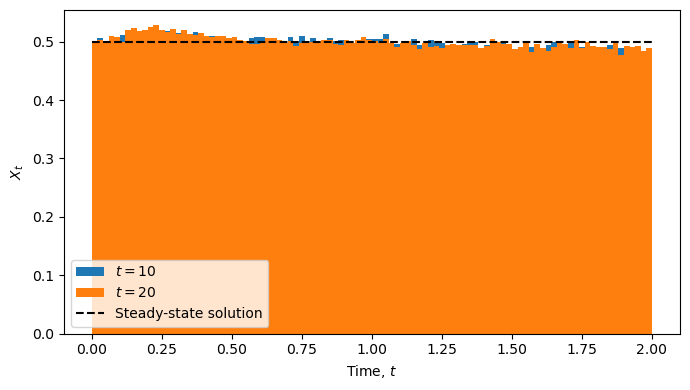

In [99]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=2, size=Np)
# Integration time
tmax = 20
# timestep
dt = 1

xmin=0
xmax=2
h = 0.1

X = solve_SDE_variable(X0*np.ones(Np), xmin, xmax, h, tmax, dt, a, b, EM, q=2)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 2, 101, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for t in [10, 20]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', density=True)
    
plt.plot([0,2], [0.5, 0.5], '--', c='k', label='Steady-state solution')
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-0.1, 2.1)
plt.legend()
plt.tight_layout()

## Absorbing boundary

Points to note about the absorbing boundary case:
* Observed distribution of solutions of the SDE depends on timestep (with long timesteps, $\Delta t$, we do not absorb particles that are inside the boundary at both $t$ and $t + \Delta t$, but would have been outside in between).
* The value of the density at the boundary is zero, which is one way to implement absorbing boundary conditions in the diffusion PDE (Dirichlet boundary condition, with $p=0$).

In [75]:
def bridge(t0, t1, x0, x1, Np, Nsteps):
    # adapted from Kloeden & Platen 1992, Eq. (1.8.7), p. 44
    dt = (t1 - t0) / Nsteps
    t  = np.linspace(t0, t1, Nsteps + 1)
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Nsteps, Np))
    W  = np.zeros((Nsteps + 1, Np))
    W[1:,:] = np.cumsum(dW, axis = 0)
    B  = x0[None,:] + W - ((t - t0)[:,None]/(t1 - t0)) * (W[-1,:] - x1 + x0)[None,:]
    return t, B

# The Euler-Maruyama method
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dta
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW, dW

# A solver wrapper that can take a boundary handling function
# as an extra argument
def solve_SDE_bridge(X0, xmin, xmax, tmax, dt, a, b, solver, q=2):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in trange(1, Nt):
        # Call solver once for those particles that are away from boundaries
        X[n,:], dW = solver(X[n-1,:], t, dt, a, b)
        # Find those particles that are outside
        mask = (X[n,:] < xmin) | (X[n,:] > xmax)
        
        # For those particles, create a higher resolution W, and try again
        N = np.sum(mask)
        _, B = bridge(t, t+dt, np.zeros(N), dW[mask], N, q)
        
        assert np.all(np.abs((B[-1,:] - B[0,:]) - dW[mask]) < 1e-9)
        X_ = X[n-1,mask]
        # Freeze coefficients
        a_ = lambda x, t : a(X[n-1,mask], t)
        b_ = lambda x, t : b(X[n-1,mask], t)
        for i in range(q):
            X_, _ = solver(X_, t, dt/q, a_, b_, dW=B[i+1,:] - B[i,:])
            X_ = reflect(X_, xmin=xmin, xmax=xmax)
        X[n,mask] = X_
        t += dt
    return X

def reflect(X, xmin=0, xmax = 2):
    # Reflect as many times as needed, until all particles are inside
    while np.any((X < xmin) | (X > xmax)): # Note that | is shorthand for np.logical_or in this case
        X = np.where(X < xmin, X+2*(xmin - X), X)
        X = np.where(X > xmax, X+2*(xmax - X), X)
    return X

  0%|          | 0/20 [00:00<?, ?it/s]

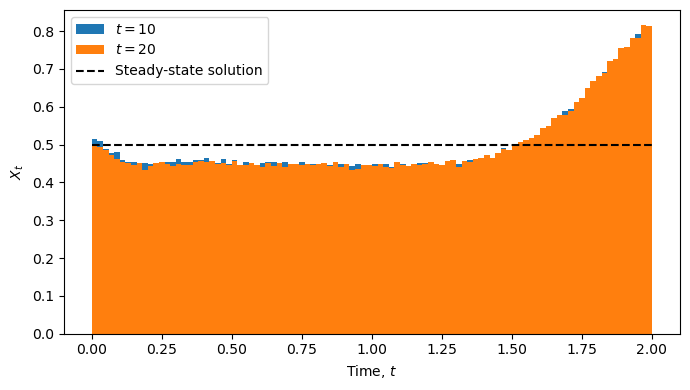

In [76]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=2, size=Np)
# Integration time
tmax = 20
# timestep
dt = 1

xmin=0
xmax=2
h = 0.1

X = solve_SDE_bridge(X0*np.ones(Np), xmin, xmax, tmax, dt, a, b, EM, q=10)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 2, 101, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for t in [10, 20]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', density=True)
    
plt.plot([0,2], [0.5, 0.5], '--', c='k', label='Steady-state solution')
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-0.1, 2.1)
plt.legend()
plt.tight_layout()

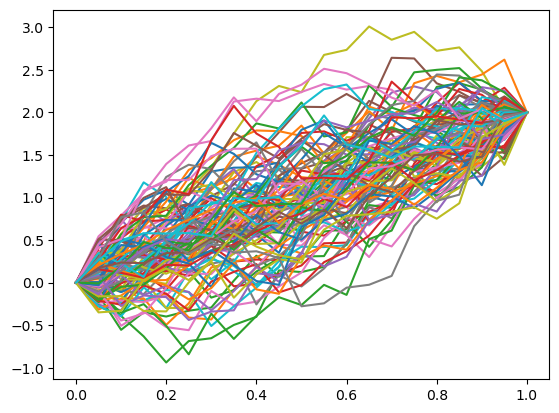

In [100]:
def bridge(t0, t1, x0, x1, Np, Nsteps):
    # adapted from Kloeden & Platen 1992, Eq. (1.8.7), p. 44
    dt = (t1 - t0) / Nsteps
    t  = np.linspace(t0, t1, Nsteps + 1)
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = (Nsteps, Np))
    W  = np.zeros((Nsteps + 1, Np))
    W[1:,:] = np.cumsum(dW, axis = 0)
    B  = x0[None,:] + W - ((t - t0)[:,None]/(t1 - t0)) * (W[-1,:] - x1 + x0)[None,:]
    return t, B

Np = 100

t, B = bridge(0, 1, np.zeros(Np), 2+np.zeros(Np), Np, 20)

for i in range(B.shape[1]):
    plt.plot(t, B[:,i])

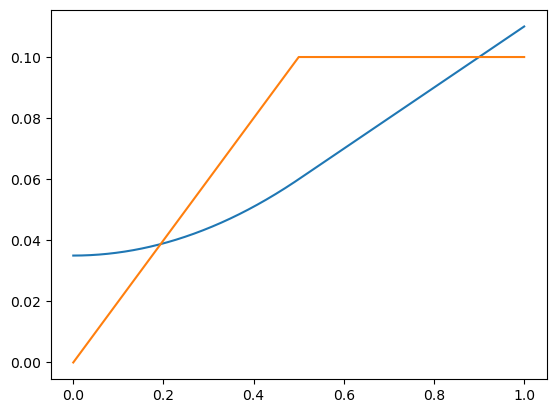

In [85]:
def K(x, h=0.5):
    K0 = 0.01
    K1 = 0.1
    return np.where(x < h, K0 + K1*(h + x**2 / h)/2, K0 + K1*x)

def ddx(f, x, dx=1e-8):
    return (f(x+dx/2) - f(x-dx/2)) / dx

x = np.linspace(0, 1, 1001)

plt.plot(x, K(x, 0.5))

plt.plot(x, ddx(K, x))

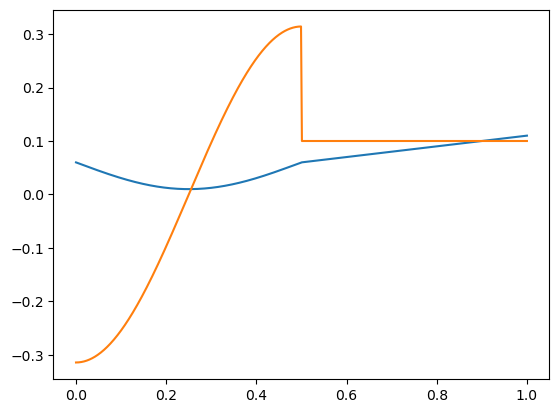

In [93]:
def K(x, h=0.5):
    K0 = 0.01
    K1 = 0.1
    return np.where(x < h, K0 + K1*h*(1 + np.sin(-np.pi + np.pi*x/h)), K0 + K1*x)

def ddx(f, x, dx=1e-8):
    return (f(x+dx/2) - f(x-dx/2)) / dx

x = np.linspace(0, 1, 1001)

plt.plot(x, K(x, 0.5))

plt.plot(x, ddx(K, x))

## References

Kloeden & Platen (1992), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5